In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import nbimporter
from diametre_monnaie import conversion_piece

In [53]:
image_path = '../DataBase/image7.jpg' 

reference_object_mm = 22.6  # diamètre de la pièce de monnaie en mm 

# Les dimensions réelles en millimètres de la piece 

diametre_reel_mm = 20  # Diamètre réel du filetage en mm  
pas_reel_mm = 25.4 / 14 # Pas réel du filetage en mm

In [54]:
def draw_tooth_pattern(image_path, diametre_reel_mm, pas_reel_mm, reference_object_mm, rotation):
    # Supposons que cette fonction retourne la taille en pixels du diamètre réel
    size_pixels = conversion_piece(image_path, reference_object_mm)
    
    if size_pixels <= 0:
        raise ValueError("La taille en pixels doit être positive et non nulle")

    pas_pixels = pas_reel_mm / size_pixels
    tooth_height = max(int(1 / size_pixels), 1)  # Assurez-vous que la hauteur est au moins 1
    
    pattern_width = int(pas_pixels) * 4  # Largeur pour 4 dents
    
    pattern_image = np.zeros((tooth_height, pattern_width), dtype=np.uint8)
    
    # Dessiner 4 dents
    for i in range(4):
        start_x = int(i * pas_pixels + pas_pixels * 0.25)
        end_x = int((i + 1) * pas_pixels - pas_pixels * 0.25)
        middle_x = int((start_x + end_x) / 2)
        
        cv2.line(pattern_image, (start_x, tooth_height - 1), (middle_x, 0), 255, 1)
        cv2.line(pattern_image, (middle_x, 0), (end_x, tooth_height - 1), 255, 1)

    if rotation:
        pattern_image = cv2.rotate(pattern_image, cv2.ROTATE_180)

    return pattern_image

In [55]:
pattern_image = draw_tooth_pattern(image_path,diametre_reel_mm,pas_reel_mm,reference_object_mm,False)
cv2.imwrite('pattern_image.jpg', pattern_image)

True

In [56]:
def match(template,img_path):
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    
    return img,res,max_val

In [57]:
img, res, max_val = match(pattern_image, image_path)
cv2.imwrite('matched_image.jpg', img)

True

In [58]:
def extract_line_pixels(img, start_point, end_point):

    num_points = abs(end_point[1] - start_point[1])  # Nombre de points basé sur la hauteur
    x_values = np.linspace(start_point[0], end_point[0], num_points).astype(int)
    y_values = np.linspace(start_point[1], end_point[1], num_points).astype(int)
    
    pixel_values = img[y_values, x_values]
    
    return pixel_values

In [78]:
def match_and_draw_normal_and_analyze(image_path, diametre_reel_mm, pas_reel_mm, reference_object_mm, rotation):

    template = draw_tooth_pattern(image_path, diametre_reel_mm, pas_reel_mm, reference_object_mm, rotation)
    img_with_rectangle, res, max_val = match(template, image_path)
    
    img_color = cv2.imread(image_path)  # Recharger l'image en couleur pour les opérations de flou
    
    taille_noyau = (5, 5)
    sigma = 0
    blurred_image = cv2.GaussianBlur(img_color, taille_noyau, sigma)
    
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh = cv2.bitwise_not(thresh)
    
    cv2.imwrite('try.jpg', thresh)
    w, h = template.shape[::-1]
    top_left = cv2.minMaxLoc(res)[3]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    center = ((top_left[0] + bottom_right[0]) // 2, (top_left[1] + bottom_right[1]) // 2)
    
    length = 2000 #à ajuster
    start_point = (center[0], center[1] - length // 2)
    end_point = (center[0], center[1] + length // 2)
    
    pixel_values = extract_line_pixels(gray, start_point, end_point)
    

    return pixel_values  # Renvoyer les valeurs pour analyse

In [79]:
img_color, res, max_val = match_and_draw_normal(image_path, diametre_reel_mm, pas_reel_mm, reference_object_mm, False)
cv2.imwrite('matched_image_with_normal.jpg', img_color)

True

In [80]:
pixel_values = match_and_draw_normal_and_analyze(image_path, diametre_reel_mm, pas_reel_mm, reference_object_mm, False)

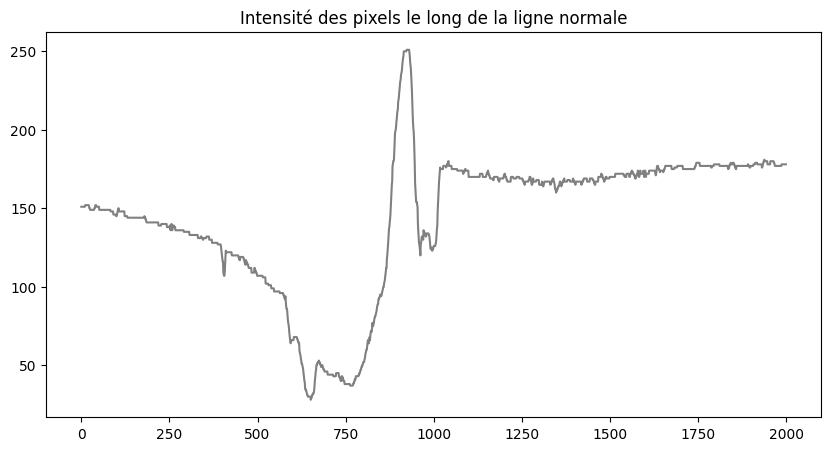

In [81]:
plt.figure(figsize=(10, 5))

plt.plot(pixel_values, color='gray')
    
plt.title('Intensité des pixels le long de la ligne normale')
plt.show()